In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import utils as ut

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_colwidth', 1000)

In [33]:
demo_j = ut.import_and_decode('data/demo_j.xpt') # demographics
diq_j = ut.import_and_decode('data/diq_j.xpt') # diabetes
huq_j = ut.import_and_decode('data/huq_j.xpt') # hospital utilization and access to care
mcq_j = ut.import_and_decode('data/mcq_j.xpt') # medical conditions
rxq_rx_j = ut.import_and_decode('data/rxq_rx_j.xpt') # prescription drug use
rhq_j = ut.import_and_decode('data/rhq_j.xpt') # reproductive health


In [34]:
# demographic info is in this df

demo_j

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,93703.00000,10.00000,2.00000,2.00000,2.00000,nan,5.00000,6.00000,2.00000,27.00000,nan,nan,1.00000,1.00000,nan,nan,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,nan,nan,nan,nan,5.00000,5.00000,3.00000,0.00000,0.00000,1.00000,2.00000,3.00000,1.00000,3.00000,9246.49186,8539.73135,2.00000,145.00000,15.00000,15.00000,5.00000
1,93704.00000,10.00000,2.00000,1.00000,2.00000,nan,3.00000,3.00000,1.00000,33.00000,nan,nan,1.00000,1.00000,nan,nan,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,nan,nan,nan,nan,4.00000,4.00000,2.00000,0.00000,0.00000,1.00000,2.00000,3.00000,1.00000,2.00000,37338.76834,42566.61475,1.00000,143.00000,15.00000,15.00000,5.00000
2,93705.00000,10.00000,2.00000,2.00000,66.00000,nan,4.00000,4.00000,2.00000,nan,2.00000,nan,1.00000,1.00000,nan,nan,2.00000,3.00000,nan,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,1.00000,1.00000,0.00000,0.00000,1.00000,2.00000,4.00000,1.00000,2.00000,nan,8614.57117,8338.41979,2.00000,145.00000,3.00000,3.00000,0.82000
3,93706.00000,10.00000,2.00000,1.00000,18.00000,nan,5.00000,6.00000,2.00000,222.00000,2.00000,nan,1.00000,1.00000,nan,15.00000,nan,nan,nan,1.00000,2.00000,2.00000,nan,nan,nan,1.00000,2.00000,2.00000,1.00000,5.00000,5.00000,0.00000,0.00000,1.00000,1.00000,4.00000,3.00000,1.00000,2.00000,8548.63262,8723.43981,2.00000,134.00000,nan,nan,nan
4,93707.00000,10.00000,2.00000,1.00000,13.00000,nan,5.00000,7.00000,2.00000,158.00000,nan,nan,1.00000,1.00000,nan,6.00000,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,7.00000,7.00000,0.00000,3.00000,0.00000,1.00000,3.00000,2.00000,1.00000,3.00000,6769.34457,7064.60973,1.00000,138.00000,10.00000,10.00000,1.88000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9249,102952.00000,10.00000,2.00000,2.00000,70.00000,nan,5.00000,6.00000,2.00000,nan,2.00000,nan,2.00000,1.00000,7.00000,nan,3.00000,1.00000,nan,1.00000,2.00000,1.00000,1.00000,2.00000,1.00000,1.00000,2.00000,1.00000,nan,2.00000,2.00000,0.00000,0.00000,2.00000,2.00000,4.00000,2.00000,1.00000,1.00000,16896.27620,18338.71110,2.00000,138.00000,4.00000,4.00000,0.95000
9250,102953.00000,10.00000,2.00000,1.00000,42.00000,nan,1.00000,1.00000,2.00000,nan,2.00000,nan,2.00000,2.00000,77.00000,nan,3.00000,4.00000,nan,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,3.00000,2.00000,2.00000,nan,61630.38001,63661.95157,2.00000,137.00000,12.00000,12.00000,nan
9251,102954.00000,10.00000,2.00000,2.00000,41.00000,nan,4.00000,4.00000,1.00000,nan,2.00000,nan,1.00000,1.00000,nan,nan,5.00000,5.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,7.00000,7.00000,3.00000,1.00000,0.00000,2.00000,3.00000,2.00000,2.00000,nan,17160.89527,17694.78335,1.00000,144.00000,10.00000,10.00000,1.18000
9252,102955.00000,10.00000,2.00000,2.00000,14.00000,nan,4.00000,4.00000,2.00000,175.00000,nan,nan,1.00000,1.00000,nan,8.00000,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,1.00000,2.00000,2.00000,1.00000,4.00000,4.00000,0.00000,1.00000,0.00000,2.00000,3.00000,2.00000,1.00000,2.00000,14238.44592,14871.83964,1.00000,136.00000,9.00000,9.00000,2.24000


In [35]:
# check for duplicate participant ID numbers

demo_j['SEQN'].duplicated().sum()

0

In [36]:
# create age df to join later

age = demo_j[['SEQN', 'RIDAGEYR']]

In [37]:
age['RIDAGEYR'].value_counts()

80.00000    427
0.00000     357
2.00000     242
1.00000     234
9.00000     199
10.00000    199
8.00000     195
11.00000    189
3.00000     185
4.00000     180
5.00000     178
7.00000     168
6.00000     165
14.00000    159
16.00000    157
12.00000    156
13.00000    152
17.00000    148
61.00000    145
18.00000    144
19.00000    143
60.00000    141
15.00000    135
63.00000    129
62.00000    123
55.00000    121
64.00000    112
33.00000    104
56.00000    104
66.00000    103
54.00000     99
52.00000     99
57.00000     97
41.00000     96
29.00000     95
65.00000     93
32.00000     92
24.00000     92
67.00000     91
22.00000     90
59.00000     90
71.00000     89
26.00000     89
36.00000     88
46.00000     86
42.00000     85
30.00000     85
28.00000     85
47.00000     85
69.00000     85
45.00000     85
39.00000     85
70.00000     83
68.00000     82
38.00000     82
34.00000     82
48.00000     82
35.00000     81
37.00000     81
50.00000     80
23.00000     80
44.00000     79
53.00000

Text(0.5, 1.0, 'NHANES Participant Age Distribution, 2017-2018')

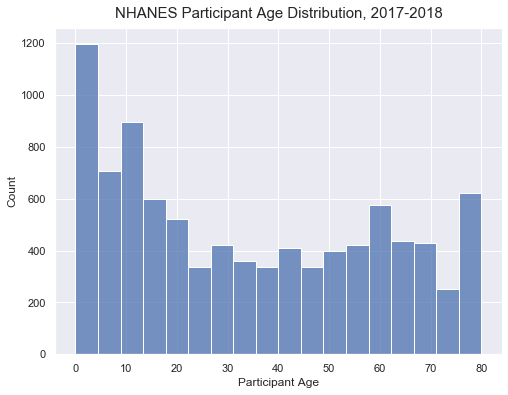

In [38]:
# view age distribution

sns.set(rc={'figure.figsize':(8, 6)})
ax = sns.histplot(age['RIDAGEYR'])
ax.set(xlabel='Participant Age')
ax.set_title('NHANES Participant Age Distribution, 2017-2018', fontsize=15, pad=10)

# all respondents 80 and older are top-coded at 80

In [39]:
# target can be found in this df
# target is HUD071 - were you a pt in a hospital during the past 12 months?

huq_j.head(200)

,SEQN,HUQ010,HUQ020,HUQ030,HUQ041,HUQ051,HUQ061,HUQ071,HUD080,HUQ090
0,93703.00000,1.00000,3.00000,1.00000,2.00000,3.00000,nan,2.00000,nan,nan
1,93704.00000,1.00000,3.00000,1.00000,2.00000,2.00000,nan,2.00000,nan,nan
2,93705.00000,3.00000,3.00000,1.00000,1.00000,2.00000,nan,2.00000,nan,2.00000
3,93706.00000,1.00000,3.00000,1.00000,2.00000,2.00000,nan,2.00000,nan,2.00000
4,93707.00000,3.00000,3.00000,1.00000,2.00000,1.00000,nan,2.00000,nan,1.00000
5,93708.00000,3.00000,3.00000,1.00000,2.00000,3.00000,nan,2.00000,nan,2.00000
6,93709.00000,4.00000,3.00000,1.00000,2.00000,3.00000,nan,2.00000,nan,2.00000
7,93710.00000,2.00000,nan,1.00000,2.00000,4.00000,nan,2.00000,nan,nan
8,93711.00000,1.00000,3.00000,1.00000,2.00000,3.00000,nan,2.00000,nan,2.00000
9,93712.00000,3.00000,1.00000,1.00000,1.00000,1.00000,nan,2.00000,nan,1.00000


**Target question:**

HUQ071	Overnight hospital patient in last year	
During the past 12 months, were you/was SP a patient in a hospital overnight? Do not include an overnight stay in the emergency room.	

In [40]:
# create target df to join later

target = huq_j[['SEQN', 'HUQ071']]
target

,SEQN,HUQ071
0,93703.00000,2.00000
1,93704.00000,2.00000
2,93705.00000,2.00000
3,93706.00000,2.00000
4,93707.00000,2.00000
...,...,...
9249,102952.00000,2.00000
9250,102953.00000,2.00000
9251,102954.00000,2.00000
9252,102955.00000,2.00000


In [41]:
# make binary target into 0 (no) and 1 (yes), not 2 and 1

target.loc[target['HUQ071'] == 2, 'HUQ071'] = 0

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
target['HUQ071'].value_counts()

# three responses of don't know
# these rows should be removed

0.00000    8434
1.00000     817
9.00000       3
Name: HUQ071, dtype: int64

In [43]:
# remove 3 patients with '9' response ("don't know")

target = target.loc[target['HUQ071'] != 9.00000]

In [44]:
target['HUQ071'].value_counts(normalize=True)

# only 9 per cent of people were hospitalized

0.00000   0.91169
1.00000   0.08831
Name: HUQ071, dtype: float64

In [45]:
# make df to plot doughnut

target_ratio = pd.DataFrame(target['HUQ071'].value_counts(normalize=True))
target_ratio.rename(index = {0.00000: 'No', 1.00000: 'Yes'}, inplace=True)
target_ratio

,HUQ071
No,0.91169
Yes,0.08831


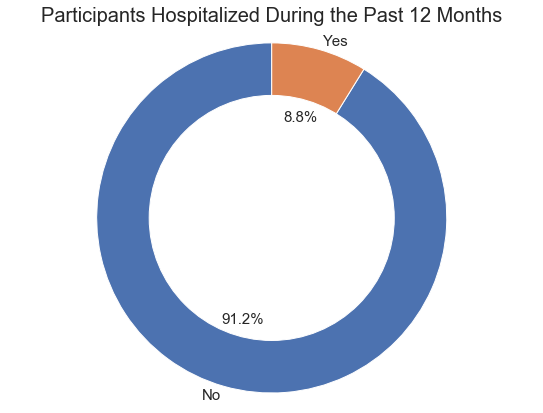

In [46]:
# plot donought chart to show target distribution
# minority class is very small

plt.rcParams['font.size'] = 15

fig1, ax1 = plt.subplots(figsize=(8,6))
ax1.pie(target_ratio['HUQ071'], 
        labels=target_ratio.index,
#        colors=['tab:blue', 'tab:orange'],
        autopct='%1.1f%%',
        labeldistance=1.05,
        startangle=90,
        textprops = {"fontsize":15})
ax1.set_title('Participants Hospitalized During the Past 12 Months', pad=10, fontsize=20)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
# plt.savefig('images/label-distribution-pie', bbox_inches='tight')

In [47]:
### https://www.hcup-us.ahrq.gov/faststats/NationalDiagnosesServlet

# start with medical conditions most likely to lead to an inpatient admission:
# circulatory system (in particular heart failure)
# respiratory system (in particular COPD)
# diabetes
# osteoarthritis
# liver conditions

# other conditions:
# also sickle cell anemia, but it's not here
# hip fractures, alcohol-related disorders, depressive disorders 

In [48]:
mcq_j

,SEQN,MCQ010,MCQ025,MCQ035,MCQ040,MCQ050,AGQ030,MCQ053,MCQ080,MCQ092,MCD093,MCQ149,MCQ151,RHD018,MCQ160A,MCD180A,MCQ195,MCQ160N,MCD180N,MCQ160B,MCD180B,MCQ160C,MCD180C,MCQ160D,MCD180D,MCQ160E,MCD180E,MCQ160F,MCD180F,MCQ160M,MCQ170M,MCD180M,MCQ160G,MCD180G,MCQ160K,MCQ170K,MCD180K,MCQ160O,MCQ160L,MCQ170L,MCD180L,MCQ500,MCQ510A,MCQ510B,MCQ510C,MCQ510D,MCQ510E,MCQ510F,MCQ520,MCQ530,MCQ540,MCQ550,MCQ560,MCQ570,MCQ203,MCQ206,MCQ220,MCQ230A,MCD240A,MCQ230B,MCD240B,MCQ230C,MCD240C,MCQ230D,MCQ300B,MCQ300C,MCQ300A,MCQ366A,MCQ366B,MCQ366C,MCQ366D,MCQ371A,MCQ371B,MCQ371C,MCQ371D,OSQ230
0,93703.00000,2.00000,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,93704.00000,2.00000,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,93705.00000,1.00000,10.00000,2.00000,nan,nan,nan,2.00000,2.00000,2.00000,nan,nan,nan,nan,1.00000,64.00000,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,nan,2.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,1.00000,1.00000,2.00000,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,1.00000,1.00000,2.00000
3,93706.00000,2.00000,nan,nan,nan,nan,nan,2.00000,2.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,nan
4,93707.00000,2.00000,nan,nan,nan,nan,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,102952.00000,2.00000,nan,nan,nan,nan,nan,2.00000,2.00000,2.00000,nan,nan,nan,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,nan,2.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,2.00000,1.00000,1.00000,1.00000,1.00000,2.00000
8893,102953.00000,1.00000,42.00000,1.00000,1.00000,2.00000,1.00000,2.00000,1.00000,2.00000,nan,nan,nan,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,nan,2.00000,1.00000,2.00000,34.00000,nan,nan,nan,nan,nan,nan,6.00000,2.00000,nan,nan,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,1.00000,2.00000,2.00000,1.00000,1.00000,1.00000,1.00000,2.00000,2.00000,2.00000,2.00000,2.00000
8894,102954.00000,2.00000,nan,nan,nan,nan,nan,2.00000,1.00000,2.00000,nan,nan,nan,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,2.00000,nan,nan,2.00000,nan,2.00000,nan,nan,2.00000,2.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.00000,nan,nan,2.00000,2.00000,nan,2.00000,nan,2.00000,nan,nan,nan,nan,nan,nan,nan,1.0

In [49]:
med_cond = mcq_j[['SEQN',
                  'MCD180A', # age when told you had arthritis
                  'MCQ195', # which type of arthritis was it
                  'MCD180B', # age when told you had heart failure
                 'MCD180C', # age when told you had CAD
                 'MCD180D', # age when told you had angina pectoris
                 'MCD180E', # age when told you had a heart attack
                 'MCD180F', # age when told you had a stroke
                 'MCD180G', # age when told you had emphysema
                 'MCD180K', # age when told you had chronic bronchitis
                  'MCQ170K', # do you still have chronic brochitis
                 'MCQ160O', # ever told you had COPD?
                 'MCD180L', # age when told you had a liver condition
                 'MCQ170L', # do you still have a liver condition
                 'MCQ510A', # Liver condition: Fatty liver
                 'MCQ510B', # Liver condition: Liver fibrosis
                  'MCQ510C', # Liver condition: Liver cirrhosis
                 'MCQ510D', # Liver condition: Viral hepatitis
                 'MCQ510E', # Liver condition: Autoimmune hepatitis 
                 'MCQ510F', # Liver condition: Other liver disease
                 'MCD180M', # Age when told you had thyroid problem
                 'MCQ170M', # Do you still have thyroid problem
                 'MCD180N', # MCD180n - Age when told you had gout
                 'MCD240A', # Age 1st cancer (MCQ230a) diagnosed
                 'MCD240B', # Age 2nd cancer (MCQ230b) diagnosed
                 'MCD240C', # Age 3rd cancer (MCQ230c) diagnosed
                 'MCQ230A', # 1st cancer - what kind was it?
                  'MCQ230B', # 2nd cancer - what kind was it?
                  'MCQ230C', # 3rd cancer - what kind was it?
                 'MCQ025', # age when first had asthma
                 'MCQ035', # still have asthma
                 'MCQ206', # Age when told you have jaundice?
                 'MCQ300A', # Close relative had heart attack?
                 'MCQ300B', # Close relative had asthma?
                 'MCQ300C', # Close relative had diabetes?
                 'MCQ570' # Age when 1st had gallbladder surgery?
                 ]]

In [50]:
# create clean df for arthritis

arthritis = med_cond[['SEQN', 'MCQ195', 'MCD180A']]
arthritis

,SEQN,MCQ195,MCD180A
0,93703.00000,nan,nan
1,93704.00000,nan,nan
2,93705.00000,2.00000,64.00000
3,93706.00000,nan,nan
4,93707.00000,nan,nan
...,...,...,...
8892,102952.00000,nan,nan
8893,102953.00000,nan,nan
8894,102954.00000,nan,nan
8895,102955.00000,nan,nan


In [51]:
arthritis['MCQ195'].value_counts()

# Code or Value	Value Description	Count	Cumulative	Skip to Item
# 1	Osteoarthritis or degenerative arthritis	711	711	
# 2	Rheumatoid arthritis	337	1048	
# 3	Psoriatic arthritis	26	1074	
# 4	Other	175	1249	
# 7	Refused	3	1252	
# 9	Don't know	443	1695	
# .	Missing	7202	8897	

1.00000    711
9.00000    443
2.00000    337
4.00000    175
3.00000     26
7.00000      3
Name: MCQ195, dtype: int64

In [52]:
arthritis_2 = pd.get_dummies(data=arthritis, columns=['MCQ195'])
arthritis_2

,SEQN,MCD180A,MCQ195_1.0,MCQ195_2.0,MCQ195_3.0,MCQ195_4.0,MCQ195_7.0,MCQ195_9.0
0,93703.00000,nan,0,0,0,0,0,0
1,93704.00000,nan,0,0,0,0,0,0
2,93705.00000,64.00000,0,1,0,0,0,0
3,93706.00000,nan,0,0,0,0,0,0
4,93707.00000,nan,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
8892,102952.00000,nan,0,0,0,0,0,0
8893,102953.00000,nan,0,0,0,0,0,0
8894,102954.00000,nan,0,0,0,0,0,0
8895,102955.00000,nan,0,0,0,0,0,0


In [53]:
# osteoarthritis is most likely to cause hospitalization - #1

arthritis_3 = arthritis_2.rename(columns = {'MCQ195_1.0': 'osteoarthritis'})

other_arth = ['MCQ195_2.0', 'MCQ195_3.0', 'MCQ195_4.0', 'MCQ195_7.0', 'MCQ195_9.0']

arthritis_3['other_arthritis'] = arthritis_3[other_arth].sum(axis = 1)

In [54]:
arthritis_4 = arthritis_3.drop(columns = other_arth)

arthritis_4

,SEQN,MCD180A,osteoarthritis,other_arthritis
0,93703.00000,nan,0,0
1,93704.00000,nan,0,0
2,93705.00000,64.00000,0,1
3,93706.00000,nan,0,0
4,93707.00000,nan,0,0
...,...,...,...,...
8892,102952.00000,nan,0,0
8893,102953.00000,nan,0,0
8894,102954.00000,nan,0,0
8895,102955.00000,nan,0,0


In [55]:
# check value counts

print(arthritis_3['osteoarthritis'].value_counts())
print(arthritis_3['MCQ195_2.0'].value_counts())
print(arthritis_3['MCQ195_3.0'].value_counts())
print(arthritis_3['MCQ195_4.0'].value_counts())
print(arthritis_3['MCQ195_7.0'].value_counts())
print(arthritis_3['MCQ195_9.0'].value_counts())

0    8186
1     711
Name: osteoarthritis, dtype: int64
0    8560
1     337
Name: MCQ195_2.0, dtype: int64
0    8871
1      26
Name: MCQ195_3.0, dtype: int64
0    8722
1     175
Name: MCQ195_4.0, dtype: int64
0    8894
1       3
Name: MCQ195_7.0, dtype: int64
0    8454
1     443
Name: MCQ195_9.0, dtype: int64


In [56]:
# matches numbers above

print(arthritis_4['osteoarthritis'].value_counts())
print(arthritis_4['other_arthritis'].value_counts())

0    8186
1     711
Name: osteoarthritis, dtype: int64
0    7913
1     984
Name: other_arthritis, dtype: int64


In [57]:
# check that every person with arthritis has a valid age at diagnosis

arthritis_4.loc[(arthritis_4['osteoarthritis'] == 1) | 
                (arthritis_4['other_arthritis'] == 1)]['MCD180A'].value_counts()

# need to do something about 99999 (I don't know) - impute the median age


50.00000       148
60.00000       114
40.00000        90
55.00000        83
45.00000        65
65.00000        61
70.00000        54
35.00000        47
30.00000        46
80.00000        43
16.00000        38
52.00000        34
99999.00000     32
58.00000        31
49.00000        31
62.00000        30
56.00000        27
63.00000        26
67.00000        25
47.00000        25
38.00000        24
75.00000        24
53.00000        24
54.00000        23
25.00000        23
57.00000        23
59.00000        23
42.00000        21
48.00000        21
64.00000        20
44.00000        20
68.00000        20
43.00000        19
66.00000        18
28.00000        18
69.00000        18
72.00000        17
37.00000        16
61.00000        14
41.00000        14
74.00000        14
46.00000        14
32.00000        13
27.00000        13
22.00000        12
51.00000        12
20.00000        12
23.00000        12
73.00000        11
36.00000        11
39.00000        11
33.00000        10
21.00000    

In [58]:
arthritis_4['MCD180A'] = ut.replace_with_median(arthritis_4['MCD180A'], 99999.00000)
arthritis_4['MCD180A'].value_counts()

50.00000    180
60.00000    114
40.00000     90
55.00000     83
45.00000     65
65.00000     61
70.00000     54
35.00000     47
30.00000     46
80.00000     43
16.00000     38
52.00000     34
58.00000     31
49.00000     31
62.00000     30
56.00000     27
63.00000     26
67.00000     25
47.00000     25
38.00000     24
53.00000     24
75.00000     24
57.00000     23
25.00000     23
54.00000     23
59.00000     23
48.00000     21
42.00000     21
64.00000     20
44.00000     20
68.00000     20
43.00000     19
69.00000     18
66.00000     18
28.00000     18
72.00000     17
37.00000     16
74.00000     14
46.00000     14
61.00000     14
41.00000     14
27.00000     13
32.00000     13
20.00000     12
51.00000     12
23.00000     12
22.00000     12
39.00000     11
73.00000     11
36.00000     11
33.00000     10
76.00000      9
34.00000      9
21.00000      9
26.00000      9
24.00000      8
71.00000      8
78.00000      8
18.00000      8
77.00000      7
31.00000      7
29.00000      6
19.00000

In [59]:
arthritis_5 = ut.get_years(arthritis_4, 'MCD180A', 'yrs_arthritis')
arthritis_5

,SEQN,osteoarthritis,other_arthritis,yrs_arthritis
0,93703.00000,0,0,nan
1,93704.00000,0,0,nan
2,93705.00000,0,1,2.00000
3,93706.00000,0,0,nan
4,93707.00000,0,0,nan
...,...,...,...,...
8892,102952.00000,0,0,nan
8893,102953.00000,0,0,nan
8894,102954.00000,0,0,nan
8895,102955.00000,0,0,nan


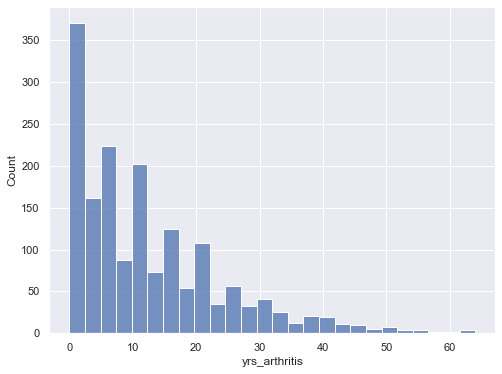

In [60]:
# no negative values, that's good

sns.histplot(arthritis_5['yrs_arthritis'])

In [62]:
arthritis_6 = arthritis_5.copy()
arthritis_6.loc[arthritis_6['osteoarthritis'] == 1, 'osteoarthritis'] = arthritis_6['yrs_arthritis']
arthritis_6.loc[arthritis_6['other_arthritis'] == 1, 'other_arthritis'] = arthritis_6['yrs_arthritis']
arthritis_6.head(200)


,SEQN,osteoarthritis,other_arthritis,yrs_arthritis
0,93703.00000,0.00000,0.00000,nan
1,93704.00000,0.00000,0.00000,nan
2,93705.00000,0.00000,2.00000,2.00000
3,93706.00000,0.00000,0.00000,nan
4,93707.00000,0.00000,0.00000,nan
5,93708.00000,0.00000,0.00000,0.00000
6,93709.00000,0.00000,28.00000,28.00000
7,93711.00000,0.00000,0.00000,nan
8,93712.00000,0.00000,0.00000,nan
9,93713.00000,0.00000,5.00000,5.00000


In [63]:
arth_yrs = arthritis_6[['SEQN', 'osteoarthritis', 'other_arthritis']]
arth_yrs.rename(columns = {'osteoarthritis': 'yrs_osteoarth', 'other_arthritis': 'yrs_other_arth'}, inplace=True)
arth_yrs.head(200)


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,SEQN,yrs_osteoarth,yrs_other_arth
0,93703.00000,0.00000,0.00000
1,93704.00000,0.00000,0.00000
2,93705.00000,0.00000,2.00000
3,93706.00000,0.00000,0.00000
4,93707.00000,0.00000,0.00000
5,93708.00000,0.00000,0.00000
6,93709.00000,0.00000,28.00000
7,93711.00000,0.00000,0.00000
8,93712.00000,0.00000,0.00000
9,93713.00000,0.00000,5.00000


In [64]:
arth_col = ['yrs_osteoarth', 'yrs_other_arth']

arth_binary = ut.make_binary(arth_yrs, arth_col)
arth_binary.head(200)

,SEQN,osteoarth_binary,other_arth_binary
0,93703.00000,0,0
1,93704.00000,0,0
2,93705.00000,0,1
3,93706.00000,0,0
4,93707.00000,0,0
5,93708.00000,0,0
6,93709.00000,0,1
7,93711.00000,0,0
8,93712.00000,0,0
9,93713.00000,0,1


In [65]:
# check arth_binary against arthritis_5
# it's good that arth_binary has fewer ppl marked with arthritis than arthritis_5
# this means that ppl diagnosed in the past year have been eliminated

print(arthritis_5['osteoarthritis'].value_counts())
print(arth_binary['osteoarth_binary'].value_counts())

0    8186
1     711
Name: osteoarthritis, dtype: int64
0    8225
1     672
Name: osteoarth_binary, dtype: int64


In [66]:
# clean up circulatory conditions

circ = med_cond[['SEQN',
                 'MCD180B', # age when told you had heart failure
                 'MCD180C', # age when told you had CAD
                 'MCD180D', # age when told you had angina pectoris
                 'MCD180E', # age when told you had a heart attack
                 'MCD180F' # age when told you had a stroke
                   ]]

In [67]:
circ_age_columns = ['MCD180B', # age when told you had heart failure
                 'MCD180C', # age when told you had CAD
                 'MCD180D', # age when told you had angina pectoris
                 'MCD180E', # age when told you had a heart attack
                 'MCD180F' # age when told you had a stroke
                   ]

for col in circ_age_columns:
    print(circ[col].value_counts())

# need to remove 99999.00000

80.00000       14
65.00000       11
60.00000       10
63.00000       10
55.00000       10
56.00000        7
69.00000        7
61.00000        7
74.00000        6
50.00000        6
45.00000        6
47.00000        5
59.00000        5
44.00000        5
72.00000        4
78.00000        4
70.00000        4
34.00000        4
73.00000        4
40.00000        4
58.00000        4
30.00000        3
54.00000        3
75.00000        3
68.00000        3
64.00000        3
57.00000        3
76.00000        3
53.00000        3
62.00000        3
16.00000        3
36.00000        3
46.00000        2
42.00000        2
71.00000        2
67.00000        2
52.00000        2
33.00000        2
28.00000        2
35.00000        2
49.00000        2
99999.00000     2
48.00000        1
79.00000        1
38.00000        1
39.00000        1
51.00000        1
18.00000        1
26.00000        1
31.00000        1
29.00000        1
19.00000        1
66.00000        1
Name: MCD180B, dtype: int64
55.00000       18


In [68]:
# replace 99999.00000 with median in all age columns

for col in circ_age_columns:
    circ[col] = ut.replace_with_median(circ[col], 99999.00000)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [69]:
# recheck age columns

for col in circ_age_columns:
    print(circ[col].value_counts())

80.00000    14
60.00000    12
65.00000    11
55.00000    10
63.00000    10
69.00000     7
61.00000     7
56.00000     7
74.00000     6
45.00000     6
50.00000     6
47.00000     5
44.00000     5
59.00000     5
73.00000     4
40.00000     4
34.00000     4
70.00000     4
72.00000     4
78.00000     4
58.00000     4
75.00000     3
36.00000     3
54.00000     3
30.00000     3
16.00000     3
68.00000     3
76.00000     3
64.00000     3
57.00000     3
53.00000     3
62.00000     3
42.00000     2
52.00000     2
33.00000     2
71.00000     2
67.00000     2
35.00000     2
49.00000     2
28.00000     2
46.00000     2
19.00000     1
29.00000     1
51.00000     1
48.00000     1
31.00000     1
38.00000     1
39.00000     1
26.00000     1
79.00000     1
18.00000     1
66.00000     1
Name: MCD180B, dtype: int64
55.00000    18
53.00000    17
50.00000    17
60.00000    16
65.00000    13
62.00000    11
68.00000     9
70.00000     9
80.00000     8
58.00000     8
59.00000     8
64.00000     7
47.00000    

In [70]:
# label heart failure - leading cause of hospitalizations

circ_2 = circ.rename(columns = {'MCD180B': 'heart_failure'})
circ_2

,SEQN,heart_failure,MCD180C,MCD180D,MCD180E,MCD180F
0,93703.00000,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan
2,93705.00000,nan,nan,nan,nan,nan
3,93706.00000,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan
...,...,...,...,...,...,...
8892,102952.00000,nan,nan,nan,nan,nan
8893,102953.00000,nan,nan,nan,nan,nan
8894,102954.00000,nan,nan,nan,nan,nan
8895,102955.00000,nan,nan,nan,nan,nan


In [71]:
# combine other circulatory conditions - use minimum age of diagnosis
# none of these have a "still have" question

other_circ_cond = ['MCD180C', 'MCD180D', 'MCD180E', 'MCD180F']

circ_2['age_oth_cond'] = circ_2[other_circ_cond].min(axis=1)
circ_2.head(200)

,SEQN,heart_failure,MCD180C,MCD180D,MCD180E,MCD180F,age_oth_cond
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,nan,nan,nan,nan,nan
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,nan,nan,nan,nan,nan
6,93709.00000,nan,nan,nan,nan,60.00000,60.00000
7,93711.00000,nan,nan,nan,nan,nan,nan
8,93712.00000,nan,nan,nan,nan,nan,nan
9,93713.00000,nan,nan,nan,nan,nan,nan


In [72]:
# drop original columns

circ_3 = circ_2.drop(columns = ['MCD180C', 'MCD180D', 'MCD180E', 'MCD180F'])
circ_3.head(200)

,SEQN,heart_failure,age_oth_cond
0,93703.00000,nan,nan
1,93704.00000,nan,nan
2,93705.00000,nan,nan
3,93706.00000,nan,nan
4,93707.00000,nan,nan
5,93708.00000,nan,nan
6,93709.00000,nan,60.00000
7,93711.00000,nan,nan
8,93712.00000,nan,nan
9,93713.00000,nan,nan


In [73]:
# get years with condition

circ_4 = ut.get_years(circ_3, 'heart_failure', 'yrs_heart_fail')
circ_5 = ut.get_years(circ_4, 'age_oth_cond', 'yrs_heart_cond')
circ_5.head(200)

,SEQN,yrs_heart_fail,yrs_heart_cond
0,93703.00000,nan,nan
1,93704.00000,nan,nan
2,93705.00000,nan,nan
3,93706.00000,nan,nan
4,93707.00000,nan,nan
5,93708.00000,nan,nan
6,93709.00000,nan,15.00000
7,93711.00000,nan,nan
8,93712.00000,nan,nan
9,93713.00000,nan,nan


In [74]:
# create final circ_yrs df

circ_yrs = circ_5.fillna(0)
circ_yrs.head(200)

,SEQN,yrs_heart_fail,yrs_heart_cond
0,93703.00000,0.00000,0.00000
1,93704.00000,0.00000,0.00000
2,93705.00000,0.00000,0.00000
3,93706.00000,0.00000,0.00000
4,93707.00000,0.00000,0.00000
5,93708.00000,0.00000,0.00000
6,93709.00000,0.00000,15.00000
7,93711.00000,0.00000,0.00000
8,93712.00000,0.00000,0.00000
9,93713.00000,0.00000,0.00000


In [75]:
# make binary circ df

circ_binary = ut.make_binary(circ_yrs, ['yrs_heart_fail', 'yrs_heart_cond'])
circ_binary.head(200)

,SEQN,heart_fail_binary,heart_cond_binary
0,93703.00000,0,0
1,93704.00000,0,0
2,93705.00000,0,0
3,93706.00000,0,0
4,93707.00000,0,0
5,93708.00000,0,0
6,93709.00000,0,1
7,93711.00000,0,0
8,93712.00000,0,0
9,93713.00000,0,0


In [76]:
# clean up respiratory conditions

resp = med_cond[['SEQN',
                'MCD180G', # age when told you had emphysema
                 'MCD180K', # age when told you had chronic bronchitis
                 'MCQ170K', # do you still have chronic bronchitis
                 'MCQ160O', # ever told you had COPD?
                 'MCQ025', # age when first had asthma
                'MCQ035' # do you still have asthma
                ]]

resp.info()

# for asthma and chronic bronc, update data to reflect whether patient still has it
# keep in mind, COPD is unusual because it's "ever told" not "age when"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8897 entries, 0 to 8896
Data columns (total 7 columns):
SEQN       8897 non-null float64
MCD180G    106 non-null float64
MCD180K    395 non-null float64
MCQ170K    395 non-null float64
MCQ160O    5569 non-null float64
MCQ025     1325 non-null float64
MCQ035     1325 non-null float64
dtypes: float64(7)
memory usage: 486.7 KB


In [77]:
# look at ages - need to replace 99999.00000

resp_col = ['MCD180G', 'MCD180K', 'MCQ025']

for col_name in resp_col:
    print(resp[col_name].value_counts().head(200))

60.00000       7
45.00000       7
50.00000       6
40.00000       4
70.00000       4
61.00000       4
67.00000       3
48.00000       3
62.00000       3
76.00000       3
53.00000       3
30.00000       3
99999.00000    3
43.00000       3
68.00000       3
54.00000       2
65.00000       2
59.00000       2
80.00000       2
39.00000       2
32.00000       2
69.00000       2
35.00000       2
58.00000       2
71.00000       2
72.00000       2
55.00000       2
36.00000       2
74.00000       2
66.00000       1
41.00000       1
44.00000       1
16.00000       1
56.00000       1
26.00000       1
28.00000       1
64.00000       1
49.00000       1
27.00000       1
47.00000       1
75.00000       1
42.00000       1
34.00000       1
33.00000       1
51.00000       1
57.00000       1
63.00000       1
52.00000       1
Name: MCD180G, dtype: int64
16.00000       81
99999.00000    18
35.00000       16
40.00000       16
25.00000       15
30.00000       15
50.00000       13
45.00000       12
55.00000    

In [78]:
for col_name in resp_col:
    resp[col_name] = ut.replace_with_median(resp[col_name], 99999.00000)

# recheck value counts

for col_name in resp_col:
    print(resp[col_name].value_counts().head(200))

60.00000    7
45.00000    7
50.00000    6
54.00000    5
40.00000    4
70.00000    4
61.00000    4
67.00000    3
48.00000    3
62.00000    3
76.00000    3
53.00000    3
30.00000    3
68.00000    3
43.00000    3
71.00000    2
55.00000    2
58.00000    2
32.00000    2
35.00000    2
65.00000    2
69.00000    2
39.00000    2
72.00000    2
36.00000    2
80.00000    2
59.00000    2
74.00000    2
16.00000    1
56.00000    1
44.00000    1
28.00000    1
64.00000    1
66.00000    1
41.00000    1
47.00000    1
75.00000    1
34.00000    1
33.00000    1
51.00000    1
57.00000    1
63.00000    1
49.00000    1
42.00000    1
52.00000    1
26.00000    1
27.00000    1
Name: MCD180G, dtype: int64
16.00000    81
34.00000    21
40.00000    16
35.00000    16
30.00000    15
25.00000    15
50.00000    13
45.00000    12
55.00000    11
20.00000    10
60.00000     9
22.00000     8
27.00000     8
32.00000     8
70.00000     7
42.00000     6
17.00000     6
80.00000     6
65.00000     6
19.00000     6
75.00000     5

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


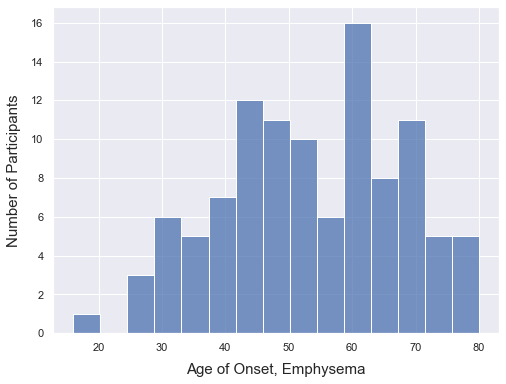

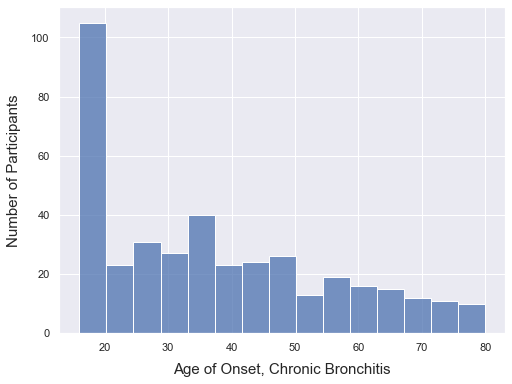

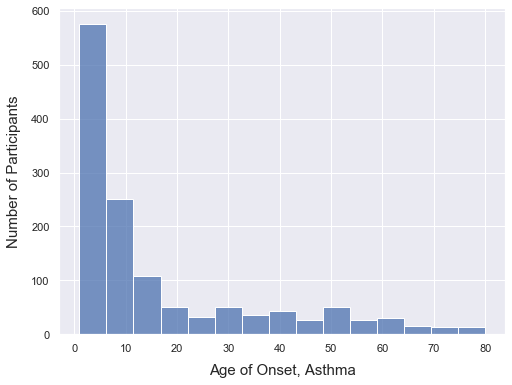

In [79]:
# check histograms
# no negative values
# for chronic bronchitis, 16 and younger is coded as 16

labels = ['Age of Onset, Emphysema',
         'Age of Onset, Chronic Bronchitis',
         'Age of Onset, Asthma']

for i, col_name in enumerate(resp_col):
    plt.figure(i)
    sns.histplot(resp[col_name], bins=15)
    plt.xlabel(labels[i], fontsize=15, labelpad=10)
    plt.ylabel('Number of Participants', fontsize=15, labelpad=10)
    

In [80]:
resp.head(200)

,SEQN,MCD180G,MCD180K,MCQ170K,MCQ160O,MCQ025,MCQ035
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,nan,nan,2.00000,10.00000,2.00000
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,nan,nan,2.00000,nan,nan
6,93709.00000,nan,nan,nan,2.00000,nan,nan
7,93711.00000,nan,nan,nan,2.00000,nan,nan
8,93712.00000,nan,nan,nan,nan,5.00000,2.00000
9,93713.00000,nan,nan,nan,2.00000,nan,nan


In [81]:
# look at values for yes/no questions - ever had COPD, still have asthma, and still have chronic bronchitis

cols_to_edit = ['MCQ160O', 'MCQ035', 'MCQ170K']
for col in cols_to_edit:
    print(resp[col].value_counts())

# change to 1 and 0 for binary instead of 1 and 2
# also change 9 (don't know) to 0
# also change 7 (refused) to 0 - just 1 value for 'Still have asthma?'
    
for col in cols_to_edit:
    resp.loc[resp[col].isin([2, 9, 7]), col] = 0

#check

print('\n', 'Updated values:', '\n')
for col in cols_to_edit:
    print(resp[col].value_counts())

2.00000    5267
1.00000     293
9.00000       9
Name: MCQ160O, dtype: int64
1.00000    825
2.00000    471
9.00000     28
7.00000      1
Name: MCQ035, dtype: int64
2.00000    209
1.00000    173
9.00000     13
Name: MCQ170K, dtype: int64

 Updated values: 

0.00000    5276
1.00000     293
Name: MCQ160O, dtype: int64
1.00000    825
0.00000    500
Name: MCQ035, dtype: int64
0.00000    222
1.00000    173
Name: MCQ170K, dtype: int64


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [82]:
# get yrs with emphysema and chronic bronchitis

resp_2 = ut.get_years(resp, 'MCD180G', 'yrs_emphysema')
resp_3 = ut.get_years(resp_2, 'MCD180K', 'yrs_chron_bronc')
resp_3.head(200)

,SEQN,MCQ170K,MCQ160O,MCQ025,MCQ035,yrs_emphysema,yrs_chron_bronc
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,0.00000,10.00000,0.00000,nan,nan
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,0.00000,nan,nan,nan,nan
6,93709.00000,nan,0.00000,nan,nan,nan,nan
7,93711.00000,nan,0.00000,nan,nan,nan,nan
8,93712.00000,nan,nan,5.00000,0.00000,nan,nan
9,93713.00000,nan,0.00000,nan,nan,nan,nan


In [83]:
# update yrs_chron_bronc to reflect whether person still has it

resp_3['yrs_chron_bronc'] = np.where(resp_3['MCQ170K'] == 0, 0, resp_3['yrs_chron_bronc'])
resp_3.head(200)

,SEQN,MCQ170K,MCQ160O,MCQ025,MCQ035,yrs_emphysema,yrs_chron_bronc
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,0.00000,10.00000,0.00000,nan,nan
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,0.00000,nan,nan,nan,nan
6,93709.00000,nan,0.00000,nan,nan,nan,nan
7,93711.00000,nan,0.00000,nan,nan,nan,nan
8,93712.00000,nan,nan,5.00000,0.00000,nan,nan
9,93713.00000,nan,0.00000,nan,nan,nan,nan


In [84]:
# get years with asthma

resp_4 = ut.get_years(resp_3, 'MCQ025', 'yrs_asthma')
resp_4.head(200)

,SEQN,MCQ170K,MCQ160O,MCQ035,yrs_emphysema,yrs_chron_bronc,yrs_asthma
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,0.00000,0.00000,nan,nan,56.00000
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,0.00000,nan,nan,nan,nan
6,93709.00000,nan,0.00000,nan,nan,nan,nan
7,93711.00000,nan,0.00000,nan,nan,nan,nan
8,93712.00000,nan,nan,0.00000,nan,nan,13.00000
9,93713.00000,nan,0.00000,nan,nan,nan,nan


In [85]:
# update yrs_chron_bronc to reflect whether person still has it

resp_4['yrs_asthma'] = np.where(resp_4['MCQ035'] == 0, 0, resp_4['yrs_asthma'])
resp_4.head(200)

,SEQN,MCQ170K,MCQ160O,MCQ035,yrs_emphysema,yrs_chron_bronc,yrs_asthma
0,93703.00000,nan,nan,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan,nan,nan
2,93705.00000,nan,0.00000,0.00000,nan,nan,0.00000
3,93706.00000,nan,nan,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan,nan,nan
5,93708.00000,nan,0.00000,nan,nan,nan,nan
6,93709.00000,nan,0.00000,nan,nan,nan,nan
7,93711.00000,nan,0.00000,nan,nan,nan,nan
8,93712.00000,nan,nan,0.00000,nan,nan,0.00000
9,93713.00000,nan,0.00000,nan,nan,nan,nan


In [86]:
# drop original columns

resp_5 = resp_4.drop(columns = ['MCQ170K', 'MCQ035'])
resp_5.head()

,SEQN,MCQ160O,yrs_emphysema,yrs_chron_bronc,yrs_asthma
0,93703.00000,nan,nan,nan,nan
1,93704.00000,nan,nan,nan,nan
2,93705.00000,0.00000,nan,nan,0.00000
3,93706.00000,nan,nan,nan,nan
4,93707.00000,nan,nan,nan,nan


In [87]:
# define final resp_yrs df

resp_yrs = resp_5.rename(columns = {'MCQ160O': 'ever_had_COPD'}).fillna(0)
resp_yrs.head(200)

,SEQN,ever_had_COPD,yrs_emphysema,yrs_chron_bronc,yrs_asthma
0,93703.00000,0.00000,0.00000,0.00000,0.00000
1,93704.00000,0.00000,0.00000,0.00000,0.00000
2,93705.00000,0.00000,0.00000,0.00000,0.00000
3,93706.00000,0.00000,0.00000,0.00000,0.00000
4,93707.00000,0.00000,0.00000,0.00000,0.00000
5,93708.00000,0.00000,0.00000,0.00000,0.00000
6,93709.00000,0.00000,0.00000,0.00000,0.00000
7,93711.00000,0.00000,0.00000,0.00000,0.00000
8,93712.00000,0.00000,0.00000,0.00000,0.00000
9,93713.00000,0.00000,0.00000,0.00000,0.00000


In [88]:
# create resp_binary df

resp_binary = ut.make_binary(resp_yrs, ['yrs_emphysema', 'yrs_chron_bronc', 'yrs_asthma'])
resp_binary.head(200)

,SEQN,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary
0,93703.00000,0.00000,0,0,0
1,93704.00000,0.00000,0,0,0
2,93705.00000,0.00000,0,0,0
3,93706.00000,0.00000,0,0,0
4,93707.00000,0.00000,0,0,0
5,93708.00000,0.00000,0,0,0
6,93709.00000,0.00000,0,0,0
7,93711.00000,0.00000,0,0,0
8,93712.00000,0.00000,0,0,0
9,93713.00000,0.00000,0,0,0


In [89]:
# clean up diabetes data

diabetes = diq_j[['SEQN',
                 'DID040', # Age when first told you had diabetes
                 'DID060', # How long taking insulin
                 'DIQ060U' # Unit of measure (month/year) - for how long taking insulin
                ]].merge(age, how='left', on='SEQN')

diabetes.head(200)

,SEQN,DID040,DID060,DIQ060U,RIDAGEYR
0,93703.00000,nan,nan,nan,2.00000
1,93704.00000,nan,nan,nan,2.00000
2,93705.00000,nan,nan,nan,66.00000
3,93706.00000,nan,nan,nan,18.00000
4,93707.00000,nan,nan,nan,13.00000
5,93708.00000,nan,nan,nan,66.00000
6,93709.00000,nan,nan,nan,75.00000
7,93711.00000,nan,nan,nan,56.00000
8,93712.00000,nan,nan,nan,18.00000
9,93713.00000,nan,nan,nan,67.00000


In [90]:
diabetes['DID040'].value_counts()

# in this data 'I don't know' is 999.00000
# and 'less than 1 year 'is 666.00000 - meaning person has been diabetic their whole life for DID040

50.00000     79
40.00000     48
45.00000     45
55.00000     45
60.00000     42
58.00000     31
59.00000     23
62.00000     23
30.00000     22
48.00000     21
65.00000     20
54.00000     20
52.00000     20
53.00000     19
47.00000     19
46.00000     18
35.00000     18
42.00000     17
38.00000     17
57.00000     17
56.00000     16
68.00000     16
70.00000     15
61.00000     14
63.00000     13
64.00000     11
80.00000     11
37.00000     11
999.00000    10
41.00000     10
49.00000      9
51.00000      8
66.00000      8
32.00000      8
33.00000      8
67.00000      7
69.00000      7
73.00000      7
25.00000      7
71.00000      6
78.00000      6
39.00000      6
43.00000      6
34.00000      6
28.00000      6
36.00000      6
44.00000      6
29.00000      5
72.00000      5
75.00000      5
76.00000      5
21.00000      4
22.00000      4
26.00000      4
20.00000      3
23.00000      3
9.00000       3
17.00000      3
18.00000      3
12.00000      3
77.00000      3
74.00000      3
16.00000

In [91]:
# replace 666.00000 with respondent's age (since they've had it their whole life)

diabetes.loc[diabetes['DID040'] == 666.00000, 'DID040'] = diabetes['RIDAGEYR']

In [92]:
diabetes['DID040'].value_counts()

50.00000     79
40.00000     48
45.00000     45
55.00000     45
60.00000     42
58.00000     31
59.00000     23
62.00000     23
30.00000     22
48.00000     21
65.00000     20
54.00000     20
52.00000     20
53.00000     19
47.00000     19
46.00000     18
35.00000     18
57.00000     17
42.00000     17
38.00000     17
68.00000     16
56.00000     16
70.00000     15
61.00000     14
63.00000     13
37.00000     11
80.00000     11
64.00000     11
41.00000     10
999.00000    10
49.00000      9
32.00000      8
51.00000      8
66.00000      8
33.00000      8
73.00000      7
67.00000      7
69.00000      7
25.00000      7
43.00000      6
34.00000      6
28.00000      6
71.00000      6
36.00000      6
78.00000      6
39.00000      6
44.00000      6
76.00000      5
72.00000      5
75.00000      5
29.00000      5
26.00000      4
21.00000      4
22.00000      4
16.00000      4
20.00000      3
9.00000       3
18.00000      3
12.00000      3
17.00000      3
23.00000      3
77.00000      3
74.00000

In [93]:
# for DID060, '666.00000' means 'less than 1 month' (taking insulin) --> replace with 0

diabetes.loc[diabetes['DID060'] == 666.00000, 'DID060'] = 0

In [94]:
# replace 999.00000 with median value

diabetes['DID040'] = ut.replace_with_median(diabetes['DID040'], 999.00000)
diabetes['DID060'] = ut.replace_with_median(diabetes['DID060'], 999.00000)

In [95]:
# drop age column so get_years function doesn't produce a duplicate column
diabetes_2 = diabetes.drop(columns = 'RIDAGEYR')

diabetes_3 = ut.get_years(diabetes_2, 'DID040', 'yrs_diabetes')

diabetes_3.head(200)

,SEQN,DID060,DIQ060U,yrs_diabetes
0,93703.00000,nan,nan,nan
1,93704.00000,nan,nan,nan
2,93705.00000,nan,nan,nan
3,93706.00000,nan,nan,nan
4,93707.00000,nan,nan,nan
5,93708.00000,nan,nan,nan
6,93709.00000,nan,nan,nan
7,93711.00000,nan,nan,nan
8,93712.00000,nan,nan,nan
9,93713.00000,nan,nan,nan


In [96]:
# check

diabetes.iloc[10]

SEQN       93714.00000
DID040        35.00000
DID060        11.00000
DIQ060U        2.00000
RIDAGEYR      54.00000
Name: 10, dtype: float64

In [97]:
# DIQ060U - Unit of measure (month/year)
# Variable Name:DIQ060USAS Label:Unit of measure (month/year)
# Code or Value
# 1	Months
# 2	Years
# .	Missing

# where unit of measurement = 1 (months), divide length of time by 12 to get years

diabetes_4 = diabetes_3.copy()
diabetes_4.loc[diabetes_4['DIQ060U'] == 1, 'DID060'] = diabetes_4['DID060'] / 12
diabetes_4.head(200)

,SEQN,DID060,DIQ060U,yrs_diabetes
0,93703.00000,nan,nan,nan
1,93704.00000,nan,nan,nan
2,93705.00000,nan,nan,nan
3,93706.00000,nan,nan,nan
4,93707.00000,nan,nan,nan
5,93708.00000,nan,nan,nan
6,93709.00000,nan,nan,nan
7,93711.00000,nan,nan,nan
8,93712.00000,nan,nan,nan
9,93713.00000,nan,nan,nan


In [98]:
# create final dm_yrs df

dm_yrs = diabetes_4[['SEQN', 'yrs_diabetes', 'DID060']].fillna(0)
dm_yrs.rename(columns = {'DID060': 'yrs_taking_ins'}, inplace=True)
dm_yrs.head(200)

,SEQN,yrs_diabetes,yrs_taking_ins
0,93703.00000,0.00000,0.00000
1,93704.00000,0.00000,0.00000
2,93705.00000,0.00000,0.00000
3,93706.00000,0.00000,0.00000
4,93707.00000,0.00000,0.00000
5,93708.00000,0.00000,0.00000
6,93709.00000,0.00000,0.00000
7,93711.00000,0.00000,0.00000
8,93712.00000,0.00000,0.00000
9,93713.00000,0.00000,0.00000


In [99]:
# make dm_binary df

dm_binary = ut.make_binary(dm_yrs, ['yrs_diabetes', 'yrs_taking_ins'])
dm_binary.head(200)

,SEQN,diabetes_binary,taking_ins_binary
0,93703.00000,0,0
1,93704.00000,0,0
2,93705.00000,0,0
3,93706.00000,0,0
4,93707.00000,0,0
5,93708.00000,0,0
6,93709.00000,0,0
7,93711.00000,0,0
8,93712.00000,0,0
9,93713.00000,0,0


In [100]:
# why is this person taking insulin but doesn't have a diabetes age when diagnosed?
# looks like there are a few SEQNs who have diabetes but have nan for age when diagnosed - just 23

diq_j.loc[diq_j['SEQN'] == 93869.00000]

,SEQN,DIQ010,DID040,DIQ160,DIQ170,DIQ172,DIQ175A,DIQ175B,DIQ175C,DIQ175D,DIQ175E,DIQ175F,DIQ175G,DIQ175H,DIQ175I,DIQ175J,DIQ175K,DIQ175L,DIQ175M,DIQ175N,DIQ175O,DIQ175P,DIQ175Q,DIQ175R,DIQ175S,DIQ175T,DIQ175U,DIQ175V,DIQ175W,DIQ175X,DIQ180,DIQ050,DID060,DIQ060U,DIQ070,DIQ230,DIQ240,DID250,DID260,DIQ260U,DIQ275,DIQ280,DIQ291,DIQ300S,DIQ300D,DID310S,DID310D,DID320,DID330,DID341,DID350,DIQ350U,DIQ360,DIQ080
161,93869.00000,1.00000,80.00000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.00000,2.00000,2.00000,1.00000,1.00000,1.00000,2.00000,0.00000,nan,1.00000,2.30000,99.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,1.00000,1.00000,1.00000,2.00000


In [101]:
dfs_to_merge = [arth_yrs, circ_yrs, resp_yrs, dm_yrs, target]

yrs_df = age.copy()

for df in dfs_to_merge:
    yrs_df = yrs_df.merge(df, how='left', on='SEQN')

yrs_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9254 entries, 0 to 9253
Data columns (total 13 columns):
SEQN               9254 non-null float64
RIDAGEYR           9254 non-null float64
yrs_osteoarth      8897 non-null float64
yrs_other_arth     8897 non-null float64
yrs_heart_fail     8897 non-null float64
yrs_heart_cond     8897 non-null float64
ever_had_COPD      8897 non-null float64
yrs_emphysema      8897 non-null float64
yrs_chron_bronc    8897 non-null float64
yrs_asthma         8897 non-null float64
yrs_diabetes       8897 non-null float64
yrs_taking_ins     8897 non-null float64
HUQ071             9251 non-null float64
dtypes: float64(13)
memory usage: 1012.2 KB


In [102]:
# the people with nulls in all the health questions are babies - remove them
# check examples:

demo_j.loc[demo_j['SEQN'] == 93710.00000]

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,FIALANG,FIAPROXY,FIAINTRP,MIALANG,MIAPROXY,MIAINTRP,AIALANGA,DMDHHSIZ,DMDFMSIZ,DMDHHSZA,DMDHHSZB,DMDHHSZE,DMDHRGND,DMDHRAGZ,DMDHREDZ,DMDHRMAZ,DMDHSEDZ,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
7,93710.00000,10.00000,2.00000,2.00000,0.00000,11.00000,3.00000,3.00000,2.00000,13.00000,nan,nan,1.00000,1.00000,nan,nan,nan,nan,nan,1.00000,1.00000,2.00000,1.00000,2.00000,2.00000,nan,nan,nan,nan,3.00000,3.00000,1.00000,0.00000,0.00000,1.00000,2.00000,3.00000,1.00000,3.00000,16418.29842,16848.02012,1.00000,134.00000,15.00000,15.00000,4.90000


In [103]:
yrs_df_2 = yrs_df.loc[~yrs_df['yrs_osteoarth'].isna()]
yrs_df_2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8897 entries, 0 to 9253
Data columns (total 13 columns):
SEQN               8897 non-null float64
RIDAGEYR           8897 non-null float64
yrs_osteoarth      8897 non-null float64
yrs_other_arth     8897 non-null float64
yrs_heart_fail     8897 non-null float64
yrs_heart_cond     8897 non-null float64
ever_had_COPD      8897 non-null float64
yrs_emphysema      8897 non-null float64
yrs_chron_bronc    8897 non-null float64
yrs_asthma         8897 non-null float64
yrs_diabetes       8897 non-null float64
yrs_taking_ins     8897 non-null float64
HUQ071             8894 non-null float64
dtypes: float64(13)
memory usage: 973.1 KB


In [104]:
# we need the target!  remove rows where target is null

yrs_df_3 = yrs_df_2.loc[~yrs_df_2['HUQ071'].isna()].set_index('SEQN')
yrs_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8894 entries, 93703.0 to 102956.0
Data columns (total 12 columns):
RIDAGEYR           8894 non-null float64
yrs_osteoarth      8894 non-null float64
yrs_other_arth     8894 non-null float64
yrs_heart_fail     8894 non-null float64
yrs_heart_cond     8894 non-null float64
ever_had_COPD      8894 non-null float64
yrs_emphysema      8894 non-null float64
yrs_chron_bronc    8894 non-null float64
yrs_asthma         8894 non-null float64
yrs_diabetes       8894 non-null float64
yrs_taking_ins     8894 non-null float64
HUQ071             8894 non-null float64
dtypes: float64(12)
memory usage: 903.3 KB


In [105]:
# minority class is just 8.5 %

yrs_df_3['HUQ071'].value_counts(normalize=True)

0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

In [106]:
yrs_df_3.to_csv('data/yrs_df')

In [107]:
# try binary

dfs_to_merge = [arth_binary, circ_binary, resp_binary, dm_binary, target]

binary_df = age.copy()

for df in dfs_to_merge:
    binary_df = binary_df.merge(df, how='left', on='SEQN')

binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9254 entries, 0 to 9253
Data columns (total 13 columns):
SEQN                  9254 non-null float64
RIDAGEYR              9254 non-null float64
osteoarth_binary      8897 non-null float64
other_arth_binary     8897 non-null float64
heart_fail_binary     8897 non-null float64
heart_cond_binary     8897 non-null float64
ever_had_COPD         8897 non-null float64
emphysema_binary      8897 non-null float64
chron_bronc_binary    8897 non-null float64
asthma_binary         8897 non-null float64
diabetes_binary       8897 non-null float64
taking_ins_binary     8897 non-null float64
HUQ071                9251 non-null float64
dtypes: float64(13)
memory usage: 1012.2 KB


In [108]:
# the people with nulls in all the health questions are babies - remove them

binary_df = binary_df.loc[~binary_df['osteoarth_binary'].isna()]
binary_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8897 entries, 0 to 9253
Data columns (total 13 columns):
SEQN                  8897 non-null float64
RIDAGEYR              8897 non-null float64
osteoarth_binary      8897 non-null float64
other_arth_binary     8897 non-null float64
heart_fail_binary     8897 non-null float64
heart_cond_binary     8897 non-null float64
ever_had_COPD         8897 non-null float64
emphysema_binary      8897 non-null float64
chron_bronc_binary    8897 non-null float64
asthma_binary         8897 non-null float64
diabetes_binary       8897 non-null float64
taking_ins_binary     8897 non-null float64
HUQ071                8894 non-null float64
dtypes: float64(13)
memory usage: 973.1 KB


In [109]:
# we need the target!  remove rows where target is null

binary_df_2 = binary_df.loc[~yrs_df_2['HUQ071'].isna()].set_index('SEQN')
binary_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8894 entries, 93703.0 to 102956.0
Data columns (total 12 columns):
RIDAGEYR              8894 non-null float64
osteoarth_binary      8894 non-null float64
other_arth_binary     8894 non-null float64
heart_fail_binary     8894 non-null float64
heart_cond_binary     8894 non-null float64
ever_had_COPD         8894 non-null float64
emphysema_binary      8894 non-null float64
chron_bronc_binary    8894 non-null float64
asthma_binary         8894 non-null float64
diabetes_binary       8894 non-null float64
taking_ins_binary     8894 non-null float64
HUQ071                8894 non-null float64
dtypes: float64(12)
memory usage: 903.3 KB


In [110]:
# minority class is just 8.5 %

binary_df_2['HUQ071'].value_counts(normalize=True)

0.00000   0.91455
1.00000   0.08545
Name: HUQ071, dtype: float64

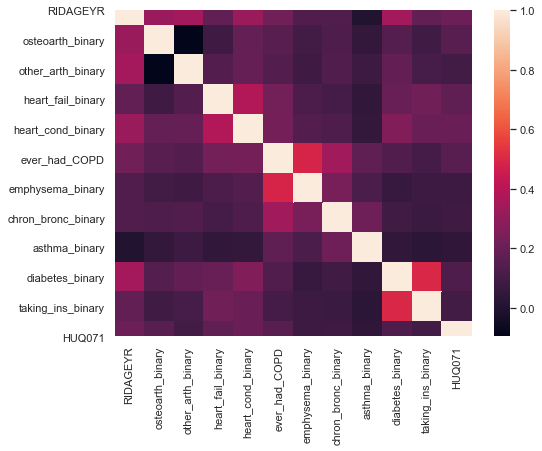

In [111]:
corr = binary_df_2.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [112]:
binary_df_2.to_csv('data/binary_df')

In [116]:
# add race

# RIDRETH3 - Race/Hispanic origin w/ NH Asian
# Variable Name:RIDRETH3SAS Label:Race/Hispanic origin w/ NH AsianEnglish Text:Recode of reported race and Hispanic origin information, with Non-Hispanic Asian CategoryTarget:Both males and females 0 YEARS - 150 YEARS
# Code or Value	Value Description	Count	Cumulative	Skip to Item
# 1	Mexican American	1367	1367	
# 2	Other Hispanic	820	2187	
# 3	Non-Hispanic White	3150	5337	
# 4	Non-Hispanic Black	2115	7452	
# 6	Non-Hispanic Asian	1168	8620	
# 7	Other Race - Including Multi-Racial	634	9254	
# .	Missing	0	9254	

race = demo_j[['SEQN', 'RIDRETH3']]
race_2 = pd.get_dummies(race, columns=['RIDRETH3'])
race_3 = race_2.drop(columns = ['RIDRETH3_7.0'])
race_3

,SEQN,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0
0,93703.00000,0,0,0,0,1
1,93704.00000,0,0,1,0,0
2,93705.00000,0,0,0,1,0
3,93706.00000,0,0,0,0,1
4,93707.00000,0,0,0,0,0
...,...,...,...,...,...,...
9249,102952.00000,0,0,0,0,1
9250,102953.00000,1,0,0,0,0
9251,102954.00000,0,0,0,1,0
9252,102955.00000,0,0,0,1,0


In [117]:
binary_df_3 = binary_df_2.merge(race_3, how='left', on='SEQN').set_index('SEQN')
binary_df_3.head(200)

,RIDAGEYR,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,HUQ071,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0
SEQN,,,,,,,,,,,,,,,,,
93703.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1
93704.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0
93705.00000,66.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0
93706.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1
93707.00000,13.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0
93708.00000,66.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1
93709.00000,75.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0
93711.00000,56.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1
93712.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,0,0,0,0


In [118]:
binary_df_3.to_csv('data/binary_df_3')

In [119]:
# explore prescription drug use table

rxq_rx_j.head(200)

,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDRSC1,RXDRSC2,RXDRSC3,RXDRSD1,RXDRSD2,RXDRSD3,RXDCOUNT
0,93703.00000,2.00000,,,nan,nan,,,,,,,nan
1,93704.00000,2.00000,,,nan,nan,,,,,,,nan
2,93705.00000,1.00000,ENALAPRIL; HYDROCHLOROTHIAZIDE,d03740,1.00000,5475.00000,I10,,,Essential (primary) hypertension,,,3.00000
3,93705.00000,1.00000,MELOXICAM,d04532,1.00000,61.00000,M06.9,,,"Rheumatoid arthritis, unspecified",,,3.00000
4,93705.00000,1.00000,OMEPRAZOLE,d00325,1.00000,3650.00000,R12,,,Heartburn,,,3.00000
5,93706.00000,2.00000,,,nan,nan,,,,,,,nan
6,93707.00000,2.00000,,,nan,nan,,,,,,,nan
7,93708.00000,1.00000,AMLODIPINE,d00689,2.00000,1460.00000,I10,,,Essential (primary) hypertension,,,3.00000
8,93708.00000,1.00000,LOSARTAN,d03821,2.00000,3650.00000,I10,,,Essential (primary) hypertension,,,3.00000
9,93708.00000,1.00000,SIMVASTATIN,d00746,2.00000,3650.00000,E78.0,,,Pure hypercholesterolemia,,,3.00000


In [120]:
rxq_rx_j['SEQN'].nunique()

9254

In [121]:
rxq_rx_j.duplicated().sum()

# looks like there are a few true duplicate lines in the data

15

In [122]:
# view duplicates
# looks like data entry errors - eliminate duplicates

dups = rxq_rx_j.loc[rxq_rx_j.duplicated(keep = False) == True].sort_values(by=['SEQN'], ascending=True).head(200)
dups

,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDRSC1,RXDRSC2,RXDRSC3,RXDRSD1,RXDRSD2,RXDRSD3,RXDCOUNT
899,94109.00000,1.00000,ALBUTEROL,d00749,1.00000,1825.00000,J45,,,Asthma,,,5.00000
900,94109.00000,1.00000,ALBUTEROL,d00749,1.00000,1825.00000,J45,,,Asthma,,,5.00000
4092,95596.00000,1.00000,ALBUTEROL,d00749,1.00000,6.00000,J20.9,,,"Acute bronchitis, unspecified",,,7.00000
4093,95596.00000,1.00000,ALBUTEROL,d00749,1.00000,6.00000,J20.9,,,"Acute bronchitis, unspecified",,,7.00000
5929,96435.00000,1.00000,ALBUTEROL,d00749,1.00000,1460.00000,J45,,,Asthma,,,4.00000
5930,96435.00000,1.00000,ALBUTEROL,d00749,1.00000,1460.00000,J45,,,Asthma,,,4.00000
7262,97058.00000,1.00000,PIOGLITAZONE,d04442,1.00000,7300.00000,E11,,,Type 2 diabetes mellitus,,,10.00000
7263,97058.00000,1.00000,PIOGLITAZONE,d04442,1.00000,7300.00000,E11,,,Type 2 diabetes mellitus,,,10.00000
8935,97871.00000,1.00000,ATORVASTATIN,d04105,2.00000,1460.00000,E78.0P,,,Prevent high cholesterol,,,3.00000
8936,97871.00000,1.00000,ATORVASTATIN,d04105,2.00000,1460.00000,E78.0P,,,Prevent high cholesterol,,,3.00000


In [123]:
# eliminate duplicates

rx_df = rxq_rx_j.drop_duplicates()

In [124]:
# create df showing just rx and days, to create a table of how many rx per patient
# eliminate 9 (refuse to answer) and 7 (don't remember)

rx_df = rx_df[['SEQN','RXDDRUG','RXDDAYS']].loc[rx_df['RXDUSE'].isin([1,2])]

In [125]:
rx_df

,SEQN,RXDDRUG,RXDDAYS
0,93703.00000,,nan
1,93704.00000,,nan
2,93705.00000,ENALAPRIL; HYDROCHLOROTHIAZIDE,5475.00000
3,93705.00000,MELOXICAM,61.00000
4,93705.00000,OMEPRAZOLE,3650.00000
...,...,...,...
19638,102956.00000,CETIRIZINE,4.00000
19639,102956.00000,DULOXETINE,365.00000
19640,102956.00000,FLUTICASONE NASAL,4.00000
19641,102956.00000,GABAPENTIN,365.00000


In [126]:
rx_df['SEQN'].nunique()

9243

In [127]:
# still some duplicates, why?

rx_df.duplicated().sum()

10

In [128]:
# view duplicates

dups = rx_df.loc[rx_df.duplicated(keep = False) == True].sort_values(by=['SEQN'], ascending=True).head(200)
dups

,SEQN,RXDDRUG,RXDDAYS
5233,96122.00000,MONTELUKAST,3650.00000
5234,96122.00000,MONTELUKAST,3650.00000
7744,97281.00000,ALBUTEROL,2190.00000
7745,97281.00000,ALBUTEROL,2190.00000
11841,99298.00000,ALBUTEROL,2190.00000
11842,99298.00000,ALBUTEROL,2190.00000
14914,100728.00000,MELOXICAM,365.00000
14915,100728.00000,MELOXICAM,365.00000
15010,100780.00000,MORPHINE,3285.00000
15009,100780.00000,MORPHINE,3285.00000


In [129]:
# view SEQNs in original data

rxq_rx_j.loc[rxq_rx_j['SEQN'] == 102775.00000]

# I see, drugs are the same but diagnoses are different
# or RXQSEEN is different (whether interviewer saw the rx)

# looks like data entry errors - eliminate these as well, since we're just looking at counting drugs per patient

,SEQN,RXDUSE,RXDDRUG,RXDDRGID,RXQSEEN,RXDDAYS,RXDRSC1,RXDRSC2,RXDRSC3,RXDRSD1,RXDRSD2,RXDRSD3,RXDCOUNT
19238,102775.00000,1.00000,ALBUTEROL,d00749,1.00000,2555.00000,J44.9,J45,,"Chronic obstructive pulmonary disease, unspecified",Asthma,,11.00000
19239,102775.00000,1.00000,ALBUTEROL,d00749,1.00000,2555.00000,J45,,,Asthma,,,11.00000
19240,102775.00000,1.00000,ATORVASTATIN,d04105,1.00000,2555.00000,E78.0,,,Pure hypercholesterolemia,,,11.00000
19241,102775.00000,1.00000,CANAGLIFLOZIN,d08080,1.00000,1095.00000,E11,,,Type 2 diabetes mellitus,,,11.00000
19242,102775.00000,1.00000,FLUOXETINE,d00236,1.00000,2555.00000,F32.9,,,"Major depressive disorder, single episode, unspecified",,,11.00000
19243,102775.00000,1.00000,HYDROCHLOROTHIAZIDE,d00253,1.00000,2555.00000,I10,,,Essential (primary) hypertension,,,11.00000
19244,102775.00000,1.00000,INSULIN DETEMIR,d05436,1.00000,1460.00000,E11,,,Type 2 diabetes mellitus,,,11.00000
19245,102775.00000,1.00000,LISINOPRIL,d00732,1.00000,2555.00000,I10,,,Essential (primary) hypertension,,,11.00000
19246,102775.00000,1.00000,OMEPRAZOLE,d00325,1.00000,2555.00000,K21,,,Gastro-esophageal reflux disease,,,11.00000
19247,102775.00000,1.00000,PREGABALIN,d05508,1.00000,274.00000,E11.4,,,Type 2 diabetes mellitus with neurological complications,,,11.00000


In [130]:
rx_df.drop_duplicates(inplace=True)

In [131]:
# recheck duplicates

rx_df.duplicated().sum()

0

In [132]:
# mark meds taken greater than 365 as 1

rx_df.loc[rx_df['RXDDAYS'] >= 365, 'rx_one_year_plus'] = 1
rx_df

,SEQN,RXDDRUG,RXDDAYS,rx_one_year_plus
0,93703.00000,,nan,nan
1,93704.00000,,nan,nan
2,93705.00000,ENALAPRIL; HYDROCHLOROTHIAZIDE,5475.00000,1.00000
3,93705.00000,MELOXICAM,61.00000,nan
4,93705.00000,OMEPRAZOLE,3650.00000,1.00000
...,...,...,...,...
19638,102956.00000,CETIRIZINE,4.00000,nan
19639,102956.00000,DULOXETINE,365.00000,1.00000
19640,102956.00000,FLUTICASONE NASAL,4.00000,nan
19641,102956.00000,GABAPENTIN,365.00000,1.00000


In [133]:
# now need to look at same drug with different numbers of days and keep longer days

rx_df.loc[rx_df[['SEQN','RXDDRUG']].duplicated(keep = False) == True].sort_values(by=['SEQN', 'RXDDRUG', 'RXDDAYS'], ascending=True).head(200)


,SEQN,RXDDRUG,RXDDAYS,rx_one_year_plus
287,93830.00000,TAMSULOSIN,1825.00000,1.00000
288,93830.00000,TAMSULOSIN,14600.00000,1.00000
387,93875.00000,ALBUTEROL,730.00000,1.00000
388,93875.00000,ALBUTEROL,10950.00000,1.00000
873,94097.00000,ALBUTEROL,10.00000,nan
874,94097.00000,ALBUTEROL,7300.00000,1.00000
1540,94402.00000,ALBUTEROL,152.00000,nan
1541,94402.00000,ALBUTEROL,730.00000,1.00000
1542,94402.00000,FLUTICASONE; SALMETEROL,61.00000,nan
1543,94402.00000,FLUTICASONE; SALMETEROL,365.00000,1.00000


In [134]:
# drop duplicates with same SEQN and diagnosis - keep row with greatest days

rx_df.drop_duplicates(subset=['SEQN','RXDDRUG'], keep='last', inplace=True)

In [135]:
rx_df

,SEQN,RXDDRUG,RXDDAYS,rx_one_year_plus
0,93703.00000,,nan,nan
1,93704.00000,,nan,nan
2,93705.00000,ENALAPRIL; HYDROCHLOROTHIAZIDE,5475.00000,1.00000
3,93705.00000,MELOXICAM,61.00000,nan
4,93705.00000,OMEPRAZOLE,3650.00000,1.00000
...,...,...,...,...
19638,102956.00000,CETIRIZINE,4.00000,nan
19639,102956.00000,DULOXETINE,365.00000,1.00000
19640,102956.00000,FLUTICASONE NASAL,4.00000,nan
19641,102956.00000,GABAPENTIN,365.00000,1.00000


In [136]:
# number of unique patients has not changed

rx_df['SEQN'].nunique()

9243

In [137]:
rx_df_2 = rx_df.drop(columns = ['RXDDAYS', 'RXDDRUG']).fillna(0)
rx_df_2.head(200)

,SEQN,rx_one_year_plus
0,93703.00000,0.00000
1,93704.00000,0.00000
2,93705.00000,1.00000
3,93705.00000,0.00000
4,93705.00000,1.00000
5,93706.00000,0.00000
6,93707.00000,0.00000
7,93708.00000,1.00000
8,93708.00000,1.00000
9,93708.00000,1.00000


In [142]:
# get number of prescriptions per patient

rx_counts = rx_df_2.groupby(['SEQN']).sum()
rx_counts.rename(columns = {'rx_one_year_plus': 'num_rx'}, inplace=True)
rx_counts.head(200)

,num_rx
SEQN,
93703.00000,0.00000
93704.00000,0.00000
93705.00000,2.00000
93706.00000,0.00000
93707.00000,0.00000
93708.00000,3.00000
93709.00000,4.00000
93710.00000,0.00000
93711.00000,0.00000


In [143]:
len(rx_counts)

9243

In [144]:
binary_df_4 = binary_df_3.merge(rx_counts, how='left', on='SEQN').fillna(0)
binary_df_4.head(200)

,RIDAGEYR,osteoarth_binary,other_arth_binary,heart_fail_binary,heart_cond_binary,ever_had_COPD,emphysema_binary,chron_bronc_binary,asthma_binary,diabetes_binary,taking_ins_binary,HUQ071,RIDRETH3_1.0,RIDRETH3_2.0,RIDRETH3_3.0,RIDRETH3_4.0,RIDRETH3_6.0,num_rx
SEQN,,,,,,,,,,,,,,,,,,
93703.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000
93704.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,1,0,0,0.00000
93705.00000,66.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,2.00000
93706.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000
93707.00000,13.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000
93708.00000,66.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,3.00000
93709.00000,75.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,1,0,4.00000
93711.00000,56.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,1,0.00000
93712.00000,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1,0,0,0,0,0.00000


In [145]:
binary_df_4.to_csv('data/binary_df_4')

In [ ]:
# define X and y

X = binary_df_4.drop(columns = ['HUQ071'])
y = binary_df_4['HUQ071']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)



In [ ]:
# define X and y

X = binary_df_4.drop(columns = ['HUQ071','RIDRETH3_3.0','RIDAGEYR'])
y = binary_df_4['HUQ071']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)



In [ ]:
# get patients who primary diagnosis for at least one drug is unknown

unknown_rx_dx = rxq_rx_j.loc[rxq_rx_j['RXDRSC1'].isin(['99999', '55555'])]
unknown_rx_dx

In [ ]:
unk_rx_dx_unique_pts = unknown_rx_dx['SEQN'].unique()
len(unk_rx_dx_unique_pts)

In [ ]:
unk_rx_dx_unique_pts = pd.DataFrame(unk_rx_dx_unique_pts)
unk_rx_dx_unique_pts['unknown_dx'] = 1
unk_rx_dx_unique_pts.rename(columns = {0: 'SEQN'}, inplace=True)
unk_rx_dx_unique_pts

In [ ]:
binary_df_5 = binary_df_4.merge(unk_rx_dx_unique_pts, how='left', on='SEQN').fillna(0)
binary_df_5.drop(columns='rx_one_year_plus', inplace=True)
binary_df_5.set_index('SEQN', inplace=True)
binary_df_5

In [ ]:
# define X and y

X = binary_df_5.drop(columns = ['HUQ071'])
y = binary_df_5['HUQ071']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)



In [ ]:
age_to_plot = binary_df_5[['RIDAGEYR','HUQ071']]
age_to_plot

In [ ]:
sns.catplot(x="HUQ071", y="RIDAGEYR", data=binary_df_5, kind='box')

In [ ]:
sns.catplot(x="HUQ071", y="RIDAGEYR", data=binary_df_5, kind='swarm')

In [ ]:
corr = binary_df_5.corr()
sns.heatmap(corr)

# no strong correlations
# even diabetes and taking insulin is only 50% correlated
# nothing is strongly correlated with hospitalization (HUQ071)

In [ ]:
# engineer age
age

In [ ]:
age['agemap'] = age['RIDAGEYR'].map(lambda x: '0-5' if x < 5
                                    else '6-17' if x < 17
                                   else '18-49' if x < 50
                                    else '50-59' if x < 60
                                    else '60-69' if x < 70
                                   else '70+')

In [ ]:
age

In [ ]:
age_buckets = pd.get_dummies(age['agemap'])
age_buckets

In [ ]:
age_2 = age.join(age_buckets).drop(columns = ['6-17'])
age_2

In [ ]:
# childbirth - exclude 70 ppl who had babies in the past 12 months? RHQ197 - How many months ago have baby?

babies_this_year = rhq_j[['SEQN', 'RHQ197']]
babies_this_year = babies_this_year.loc[~babies_this_year['RHQ197'].isna()]
babies_this_year

In [ ]:
# join target
babies_target = babies_this_year.merge(target, how='left', on='SEQN')
babies_target

# most people who had babies within past 12 months are marked as 1 - had a hospital stay
# not all are, possibly due to differences in how ppl responded to the question?

In [ ]:
# how many in this group were hospitalized?

babies_target['HUQ071'].sum()

In [ ]:
babies_target_2 = babies_target.merge(huq_j[['SEQN', 'HUD080']], how='left', on='SEQN')
babies_target_2.fillna(0, inplace=True)

# some ppl who delivered babies were in the hospital more than once

babies_target_2['non_birth_hosp'] = babies_target_2['HUD080']
babies_target_2

In [ ]:
# remove one hospitalization from the count for child birth

babies_target_3 = babies_target_2.copy()
babies_target_3.loc[(babies_target_3['RHQ197'] <= 12) &
                    (babies_target_3['HUQ071'] != 0), 
                    'non_birth_hosp'] = babies_target_3['HUD080'] - 1
babies_target_3

In [ ]:
babies_target_3['non_birth_hosp_binary'] = np.where(babies_target_3['non_birth_hosp'] > 0, 1, 0)
babies_target_3

In [ ]:
# how many in this group were hospitalized?
babies_target_3['non_birth_hosp_binary'].sum()

In [ ]:
babies_target_final = babies_target_3[['SEQN', 'non_birth_hosp_binary']]
babies_target_final

In [ ]:
binary_df_6 = binary_df_5.merge(babies_target_final, how='left', on='SEQN')
binary_df_6

In [ ]:
binary_df_6['updated_hosp'] = np.where(~binary_df_6['non_birth_hosp_binary'].isnull(), 
                                      binary_df_6['non_birth_hosp_binary'],
                                      binary_df_6['HUQ071'])

In [ ]:
print(
     binary_df_6['HUQ071'].sum(),
     binary_df_6['updated_hosp'].sum())

In [ ]:
binary_df_7 = binary_df_6.drop(columns = ['HUQ071','non_birth_hosp_binary'])
binary_df_7.set_index('SEQN', inplace=True)

In [ ]:
X = binary_df_7.drop(columns = ['updated_hosp'])
y = binary_df_7['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)

# nice!!!


In [ ]:
sns.catplot(x="updated_hosp", y="RIDAGEYR", data=binary_df_7, kind='swarm')

In [ ]:
sns.catplot(x="updated_hosp", y="RIDAGEYR", data=binary_df_7, kind='box')

In [ ]:
age_3 = age_2.drop(columns = ['RIDAGEYR', 'agemap'])
age_3

In [ ]:
binary_df_8 = binary_df_7.merge(age_3, how='left', on='SEQN').drop(columns = 'RIDAGEYR')
binary_df_8.set_index('SEQN', inplace=True)
binary_df_8

In [ ]:
X = binary_df_8.drop(columns = ['updated_hosp'])
y = binary_df_8['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)

In [ ]:
mcq_j

In [ ]:
liver = mcq_j[['SEQN',
       'MCQ170L', # do you still have a liver condition
       'MCD180L']] #  Age when told you had a liver condition

liver


In [ ]:
liver['MCQ170L'].value_counts()

# 1 - yes
# 2 - no
# 9 - don't know


In [ ]:
liver['MCD180L'].value_counts()

# need to remove 99999.00000

In [ ]:
liver['MCD180L'] = ut.replace_with_median(liver['MCD180L'], 99999.00000)
liver['MCD180L'].value_counts()

In [ ]:
liver_2 = liver.merge(age, how='left', on='SEQN')
liver_2

In [ ]:
liver_2['yrs_with_liver'] = liver_2['RIDAGEYR'] - liver_2['MCD180L']
liver_2['liver_binary'] = np.where(liver_2['yrs_with_liver'] > 0, 1, 0)
liver_2['liver_binary'] = np.where(liver_2['MCQ170L'] == 1, liver_2['liver_binary'], 0)
liver_2.head(200)

In [ ]:
liver_3 = liver_2[['SEQN', 'liver_binary']]
liver_3['liver_binary']

In [ ]:
binary_df_9 = binary_df_8.merge(liver_3, how='left', on='SEQN').set_index('SEQN')
binary_df_9

In [ ]:
# define X and y

X = binary_df_9.drop(columns = ['updated_hosp'])
y = binary_df_9['updated_hosp']

# create holdout set

X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.07, random_state=727)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_training)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_training.index, columns=X_training.columns)

CompNB = ComplementNB()

CompNB.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, CompNB)

order_features(CompNB.coef_, X_train_scaled)

# no improvement

In [ ]:
knn = KNeighborsClassifier()

knn.fit(X_train_scaled, y_training)

k_fold_validator(X_train_scaled, y_training, knn)

# order_features(CompNB.coef_, X_train_scaled)

In [ ]:
nn = Sequential()

# Input layer with dropout
nn.add(layers.Dropout(0.3))

# First hidden layer
nn.add(layers.Dense(10, activation='relu'))
nn.add(layers.Dropout(0.3))

# Second hidden layer
nn.add(layers.Dense(10, activation='relu'))
nn.add(layers.Dropout(0.3))

# Third hidden layer
nn.add(layers.Dense(10, activation='relu'))
nn.add(layers.Dropout(0.3))

# Output layer
nn.add(layers.Dense(1, activation='linear'))

# Compile the model
nn.compile(optimizer='SGD', 
              loss='mse',  
              metrics=['accuracy']) 

# Return the compiled model


In [ ]:
y_training_array = y_training.to_numpy().reshape((8271,1))

In [ ]:
type(y_training_array)

In [ ]:
y_training_array.shape

In [ ]:
type(y_training_array[0][0])

In [ ]:
# !pip install -U tensorflow==2.4.1
# !pip install Keras==2.2.4



In [ ]:
X_train_scaled_reindex = X_train_scaled.reset_index(drop=True)
X_train_scaled_reindex

In [ ]:
# always predicting majority class

nn.fit(X_train_scaled_reindex, y_training_array, epochs=10, validation_split=0.1)